# Non-stationary internal tide analysis of IMOS mooring data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
# import h5py
from scipy import signal



from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.utils.harmonic_analysis import harmonic_fit_array

import matplotlib as mpl

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\soda\dataio\netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


In [2]:
%matplotlib notebook

In [3]:
# Define functions here


def open_bfilt_dataset(ncfile, group, highT=3):
    """
    Load band-passed variable from a dataset
    """
    myds = xr.open_dataset(ncfile,group=group)['A_n']
    ts = timeseries(myds.time.values, myds.values)
    yfilt = ts.filt([34*3600,highT*3600], btype='band')
    myds.data[:]=yfilt.T
    return myds

def harmonic_pred(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = np.ones_like(tdays) * aa
    for ii in range(nomega):
        amp += Aa[...,ii]*np.cos(omega[ii]*tdays) + Ba[...,ii]*np.sin(omega[ii]*tdays)
    
    return amp


In [4]:


figpath = '../FIGURES'

mode = 0

In [62]:
# ###
# ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
ncfile = r'C:\Projects\ARCHub\DATA\FIELD\ShellCrux\KP150_Fitted_Buoyancy_wout_motion.nc'
sitename = 'KP150'
groups = ['KP150_phs1','KP150_phs2']
badtimes = [('2016-09-15','2016-10-31') ]
ylim = (-30,30)

# ###
# ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/Prelude_Fitted_Buoyancy.nc'
# sitename = 'FBlock'
# groups = ['F_Block_2007_CM04','F_Block_2008a_CM04','F_Block_2008b_CM04',
#           'F_Block_2009a_CM04','F_Block_2009b_CM04']
# badtimes = []
# ylim = (-30,30)


# ###
# # ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/IMOS/processed_data/IMOS_Fitted_Buoyancy_Tonly.nc'
# # ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/IMOS/processed_data/IMOS_Fitted_Buoyancy_Deep_Tonly.nc'
ncfile = r'C:\Users\mrayson\cloudstor\Data\IMOS\IMOS_Fitted_Buoyancy_Tonly.nc'

# sitename = 'PIL200'
# groups = ['PIL200_2012_a','PIL200_2012_b','PIL200_2013_a','PIL200_2013_b','PIL200_2014_a']
# # badtimes = [('2013-01-30','2013-04-01'),('2013-08-03','2013-08-05')]
# badtimes = []
# ylim = (-40,40)

# # # ###
# sitename = 'KIM200'
# groups = ['KIM200_2012_a','KIM200_2012_b','KIM200_2013_a','KIM200_2013_b','KIM200_2014_a']
# badtimes = [ ('2012-05-25','2012-08-12'), ('2013-07-01','2013-07-25') ]
# # badtimes = []
# ylim = (-30,30)

# # # # ####
sitename = 'KIM400'
groups = ['KIM400_2012_a','KIM400_2012_b','KIM400_2013_a','KIM400_2013_b','KIM400_2014_a']
badtimes = [ ('2012-07-30','2012-08-12'), ('2014-07-10','2014-08-25') ]
ylim = (-30,30)

# ####
# # Lots of bad values!!
# # sitename = 'ITFMHB'
# # groups = ['ITFMHB_2012_a','ITFMHB_2012_b','ITFMHB_2013_a','ITFMHB_2013_b','ITFMHB_2014_a']
# # badtimes = [ ('2013-06-01','2013-11-18'),  ]
# # ylim = (-30,30)

# sitename = 'ITFTIS'
# groups = [
#     #'ITFTIS_2010_b','ITFTIS_2011_b',
#     'ITFTIS_2012_a',
#     'ITFTIS_2012_b',
#     'ITFTIS_2013_a',
#     'ITFTIS_2013_b',
#     'ITFTIS_2014_a',
#     #'ITFTIS_2014_b','ITFTIS_2015_a','ITFTIS_2015_b',
#     ]
# #badtimes = [ ('2012-01-07','2012-01-13'),  ]
# badtimes=[]
# ylim = (-30,30)

# Load the data
ds = xr.concat([open_bfilt_dataset(ncfile, gg, highT=6) for gg in groups], dim='time')
ds3 = xr.concat([open_bfilt_dataset(ncfile, gg, highT=3) for gg in groups], dim='time')

dsA = xr.concat([xr.open_dataset(ncfile,group=gg)['A_n'] for gg in groups], dim='time')

dsN = xr.concat([xr.open_dataset(ncfile,group=gg)['N2'] for gg in groups], dim='timeslow')
dsphi = xr.concat([xr.open_dataset(ncfile,group=gg)['phi'] for gg in groups], dim='timeslow')

# Mask out bad times
for bt in badtimes:
    t1,t2 = bt
    ds.loc[t1:t2]=np.nan
    ds3.loc[t1:t2]=np.nan
    dsA.loc[t1:t2]=np.nan
    dsN.loc[t1:t2] = np.nan
    dsphi.loc[t1:t2] = np.nan

z = dsN.z.values



In [69]:
ds

<xarray.DataArray 'A_n' (time: 1316885, modes: 4)>
array([[ 0.8026507 ,  0.19835364, -0.50327608, -0.51976815],
       [ 0.80084902,  0.18885088, -0.50920246, -0.52340446],
       [ 0.79900498,  0.17929816, -0.5151445 , -0.52704591],
       ...,
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan]])
Coordinates:
  * modes    (modes) int64 0 1 2 3
  * time     (time) datetime64[ns] 2012-02-03T15:00:01.036800 ... 2014-08-23T00:00:01.036800
Attributes:
    long_name:  Modal buoyancy amplitude
    units:      m

<IPython.core.display.Javascript object>


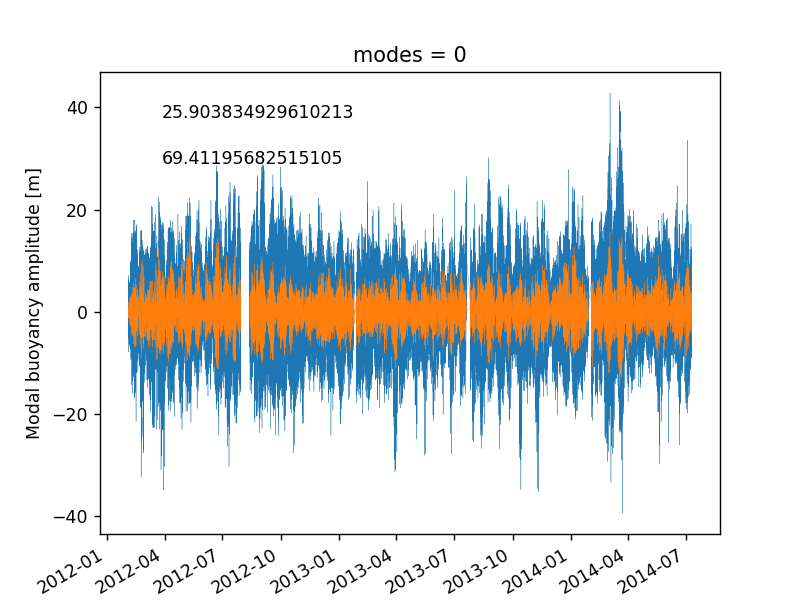

Text(0.1, 0.8, '69.41195682515105')

In [64]:
plt.figure()
dsA[:,0].plot(lw=0.2)
ds[:,0].plot(lw=0.2)
plt.text(0.1,0.9, np.nanvar(ds[:,mode].values)/np.nanvar(dsA[:,mode].values)*100, transform=plt.gca().transAxes)
plt.text(0.1,0.8, np.nanvar(ds3[:,mode].values)/np.nanvar(dsA[:,mode].values)*100, transform=plt.gca().transAxes)


<IPython.core.display.Javascript object>


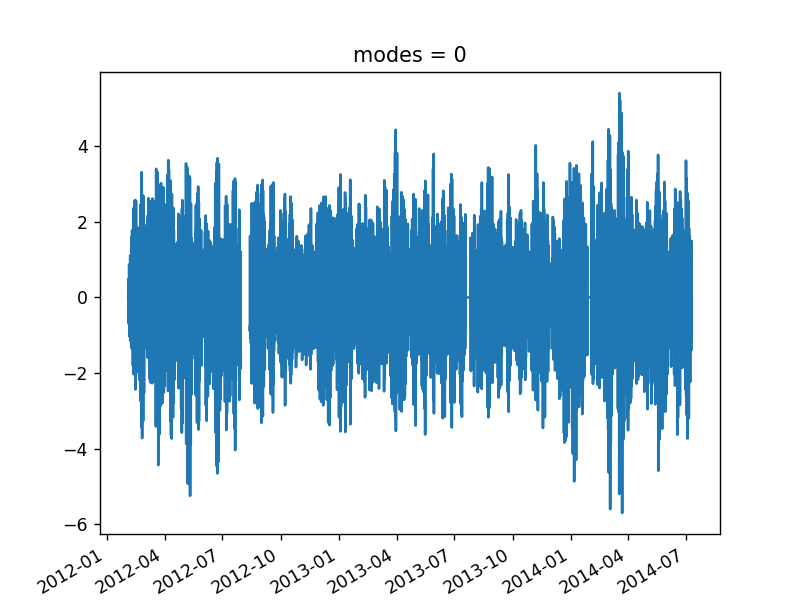

In [65]:
# Compute the a -> SSH conversion factor
sshfac = np.trapz(dsN.values*dsphi.values[:,mode,:],z) /9.81
# Interpolate the sshfac onto the amplitude time-series
sshfac_ds = xr.DataArray(sshfac, dims=('time',), coords={'time':dsN.timeslow.values} )
sshfac_ds_i = sshfac_ds.interp({'time':dsA.time})

dsSSH = (ds[:,mode]*sshfac_ds_i)*100 # cm

plt.figure()
dsSSH.plot()


In [66]:
tdaysec = 86400.

tidecons = ['M2','S2','N2','K1','O1',]
frq,names = getTideFreq(tidecons)
omega_A = 2*np.pi/(365*tdaysec)

X = ds[:,mode].values
# X = dsSSH.values

idx = ~np.isnan(X)

tnew =  ds.time.values
tsec = SecondsSince(tnew)

frq_all =[]
for ff in frq:
    for n in range(-3,4):
        frq_all.append(ff+n*omega_A)
        
Y = harmonic_fit_array(X[idx], tsec[idx], frq_all, axis=0)
aa = Y[0]
Aa = Y[1::2]
Ba = Y[2::2]

len(frq_all)
a0_nonstat = harmonic_pred(aa, Aa, Ba, frq_all, tsec)

# Fit with no nonstationary componenent
tidecons = ['M2','S2','N2','K1','O1','MA2','MB2']
frqstat,names = getTideFreq(tidecons)

Y = harmonic_fit_array(X[idx], tsec[idx], frqstat, axis=0)
aa = Y[0]
Aa = Y[1::2]
Ba = Y[2::2]

len(frq_all)
a0_stat = harmonic_pred(aa, Aa, Ba, frqstat, tsec)

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\soda\utils\harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)


<IPython.core.display.Javascript object>


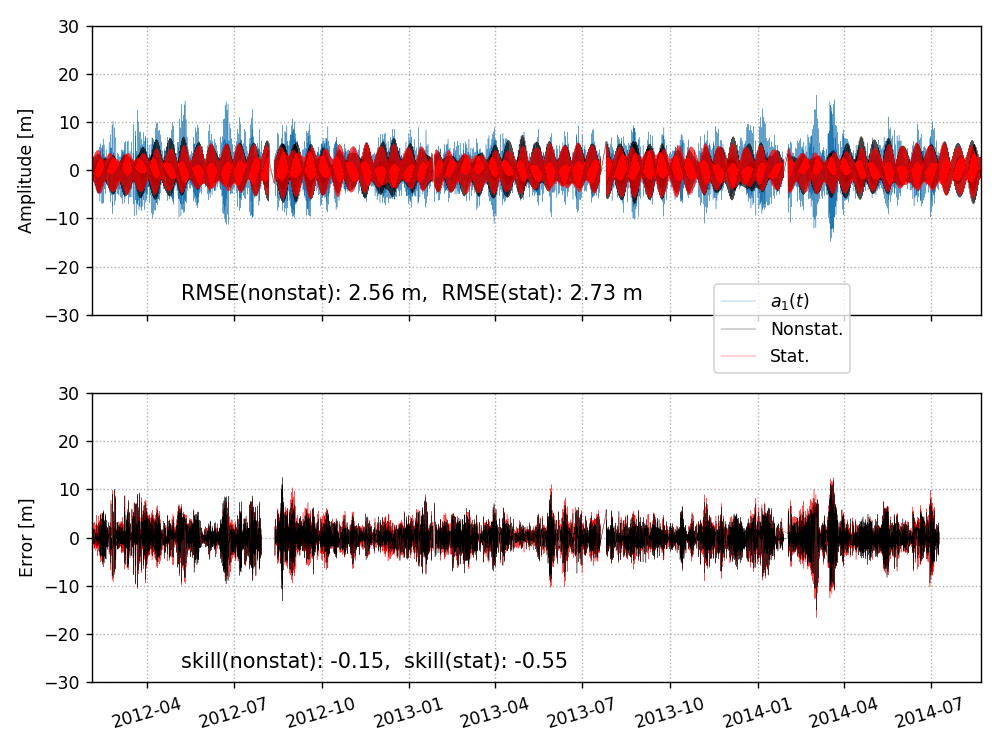

In [67]:
plt.figure(figsize=(8,6))
ax=plt.subplot(211)
plt.plot(tnew,X,lw=0.2,ls='-')
plt.plot(tnew,a0_nonstat,'k',lw=0.2)
plt.plot(tnew,a0_stat,'r',lw=0.2)


plt.text(0.1,0.05, 'RMSE(nonstat): %1.2f m,  RMSE(stat): %1.2f m'%\
         (rmse(X[idx],a0_nonstat[idx]),rmse(X[idx],a0_stat[idx])),\
         transform=ax.transAxes, fontsize=12)

plt.ylim(ylim)
# plt.grid(b=True)
plt.ylabel('Amplitude [m]')
plt.xticks(rotation=12)
plt.grid(b=True, ls=':')
ax.set_xticklabels([])
plt.xlim(tnew[0],tnew[-1])
plt.legend(('$a_1(t)$','Nonstat.','Stat.'),loc = (0.7,-.2))

ax=plt.subplot(212)

plt.plot(tnew,a0_stat-X,'r',lw=0.2)
plt.plot(tnew,a0_nonstat-X,'k',lw=0.2)

plt.text(0.1,0.05, 'skill(nonstat): %1.2f,  skill(stat): %1.2f'%\
         (skill(X[idx],a0_nonstat[idx]),skill(X[idx],a0_stat[idx])),\
         transform=ax.transAxes, fontsize=12)

# plt.text(0.1,0.05, 'skill(nonstat): %1.2f,  skill(stat): %1.2f'%\
#          ( np.var(a0_nonstat[idx])/np.var(X[idx])*100, np.var(a0_stat[idx])/np.var(X[idx])*100),\
#          transform=ax.transAxes, fontsize=12)


plt.ylim(ylim)
# plt.grid(b=True)
plt.ylabel('Error [m]')
plt.xticks(rotation=16)
plt.grid(b=True, ls=':')
plt.xlim(tnew[0],tnew[-1])

plt.tight_layout()
plt.savefig('{}/{}_a0_fits_w_error.png'.format(figpath,sitename),dpi=150)
plt.savefig('{}/{}_a0_fits_w_error.pdf'.format(figpath,sitename),dpi=150)


<IPython.core.display.Javascript object>


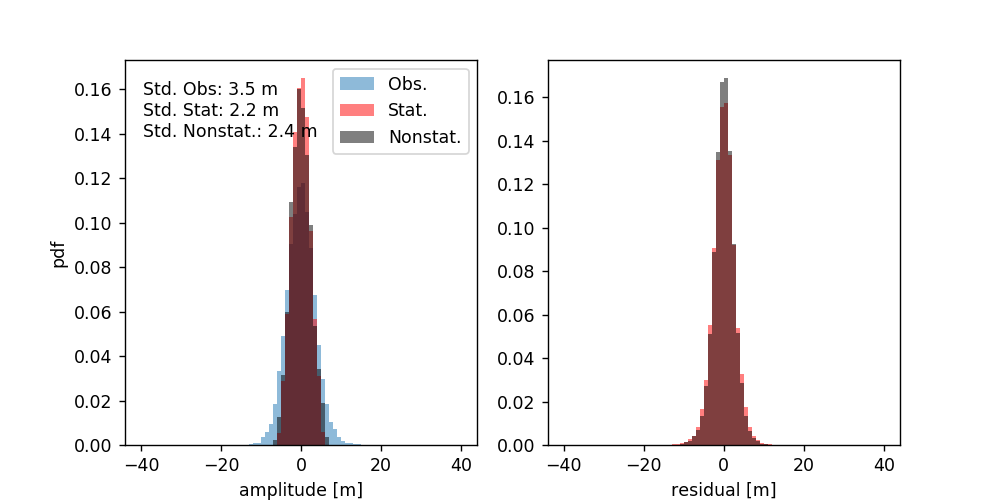

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:17: Matplotlib

In [68]:
bins = np.arange(-40,41,1)
# Histogram plots

plt.figure(figsize=(8,4))
ax=plt.subplot(121)
plt.hist(X,bins, alpha=0.5, normed=True)
plt.hist(a0_stat,bins, color= 'r',alpha=0.5, normed=True)
plt.hist(a0_nonstat,bins, color= 'k',alpha=0.5, normed=True)
plt.xlabel('amplitude [m]')
plt.ylabel('pdf')
plt.legend(('Obs.','Stat.','Nonstat.'))
plt.text(0.05,0.8,'Std. Obs: %3.1f m\nStd. Stat: %3.1f m\nStd. Nonstat.: %3.1f m'%\
         ( np.nanstd(X), a0_stat.std(), a0_nonstat.std()), transform=ax.transAxes)

plt.subplot(122)
plt.hist(a0_stat-X, bins, color= 'r',alpha=0.5, normed=True)
plt.hist(a0_nonstat-X, bins, color= 'k',alpha=0.5, normed=True)
plt.xlabel('residual [m]')

plt.savefig('{}/{}_a0_hist.png'.format(figpath,sitename),dpi=150)
plt.savefig('{}/{}_a0_hist.pdf'.format(figpath,sitename),dpi=150)

<IPython.core.display.Javascript object>


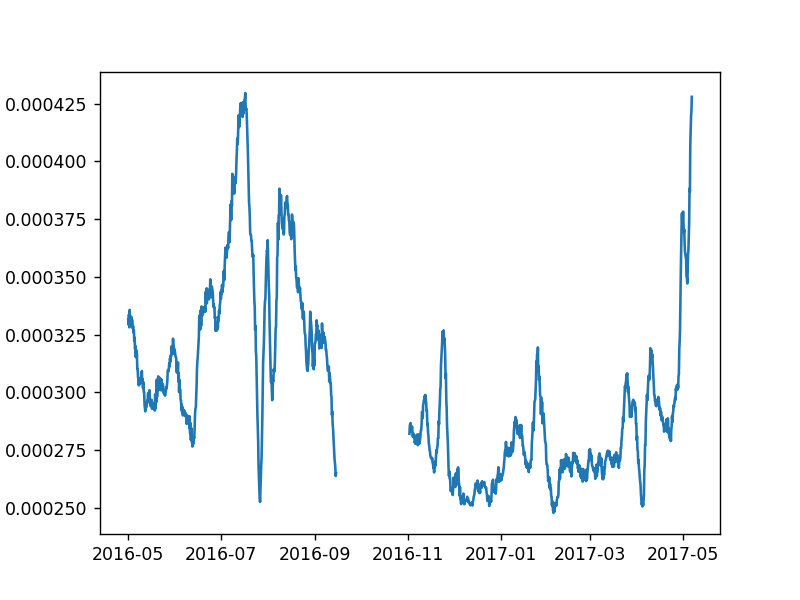

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [61]:
# Plot some of the pycnocline properties
plt.figure()
plt.plot(dsN.timeslow,dsN.max(axis=1))

# Calculate the pycnocline depth

$$
z_{pyc} = \frac{\int_{-H}^{0} z N(z) dz}{\int_{-H}^{0} N(z) dz}
$$

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


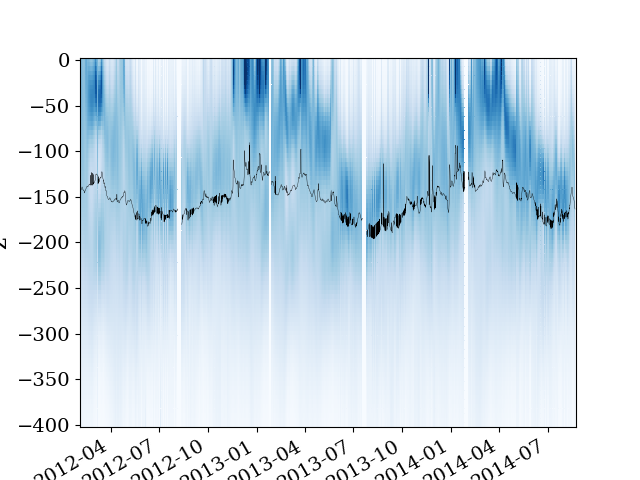

In [59]:
z = dsN.z.values
z_pyc = np.trapz(dsN.values*z,z) /np.trapz(dsN.values,z)

plt.figure()

plt.subplot(111)
#plt.xlim(dsN.timeslow[0],dsN.timeslow[-1])

dsN.T.plot(vmax=0.0005, add_colorbar=False, cmap='Blues')
plt.plot(dsN.timeslow, z_pyc,'k',lw=0.25)


<IPython.core.display.Javascript object>


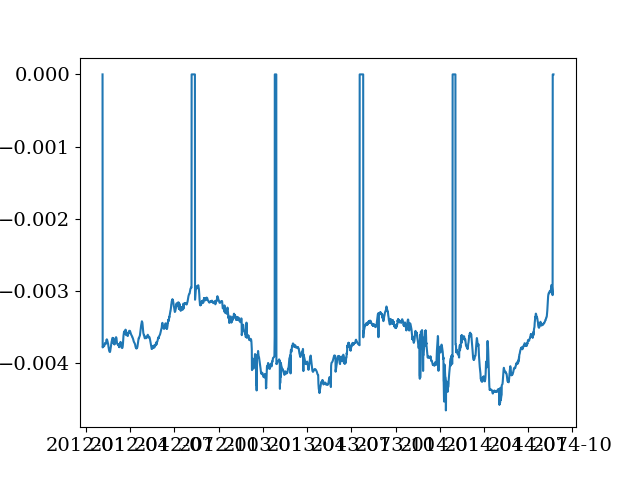

In [60]:
# Compute the a -> SSH conversion factor
sshfac = np.trapz(dsN.values*dsphi.values[:,0,:],z) /9.81
plt.figure()
plt.plot(dsN.timeslow,sshfac)

<IPython.core.display.Javascript object>


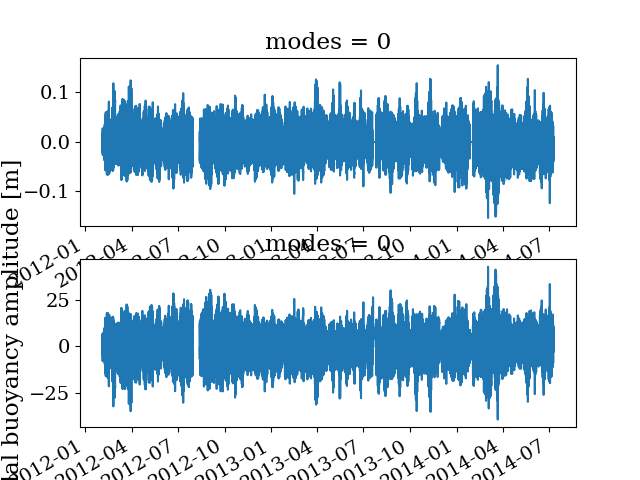

In [63]:
# Interpolate the sshfac onto the amplitude time-series
sshfac_ds = xr.DataArray(sshfac, dims=('time',), coords={'time':dsN.timeslow.values} )
sshfac_ds_i = sshfac_ds.interp({'time':dsA.time})

dsSSH = dsA[:,0]*sshfac_ds_i

plt.figure()
plt.subplot(211)
(dsA[:,0]*sshfac_ds_i).plot()
plt.subplot(212)
dsA[:,0].plot()

<xarray.DataArray (time: 1164605)>
array([-3.79926344e-09, -6.19825053e-06, -1.23927018e-05, ...,
        0.00000000e+00,  0.00000000e+00,             nan])
Coordinates:
  * time     (time) datetime64[ns] 2012-02-21T12:00:01.036800 ... 2014-08-15T20:00:01.008000